In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## saco de los subject los kinetoplastidos 

In [2]:
df = pd.read_csv('../../../../results/reciprocal_best_hit_TSV/rbh_all_in_one_file.tsv', sep='\t', index_col=0)

In [3]:
#removing tryp organisms
df = df.loc[~df['spp'].isin(['TRYCC','TRYB2','LEIIN']),:]

In [4]:
#removing duplicates because in the subject db there are proteins with two files a pdb and cif
df = df.drop_duplicates(subset = ['query_uniprot_accession', 'target_uniprot_accession'])

## df inspection and cheking
* some target are duplicated because they have a .pdb and .cif file. -> remove .cif if there is allready a .pdb #rbh return both so is not a problem for the analysis.
* some ortho groups from single members have the same structure assigned by tritrypDB. So we will find them duplicated.

In [5]:

#dataframe with GO annotation informattion
df_gene_information = pd.read_csv('../../../../config/mandatory_files/GenesByOrthologPattern_Summary.txt',
                                  sep='\t',
                                  low_memory=False)

ortho_g_count = df_gene_information.groupby('Ortholog Group').size().to_frame()

## Adding info from OG

In [6]:
df_ogup = pd.read_csv('../../../report/ortholog_groups_x_sequence_clustering_x_UNIPROT.tsv', sep='\t')

In [7]:
df_ogup = df_ogup[~df_ogup.uniprot.isna()]

In [8]:
print('Total amount of cluster with protein structure assigned:')
print(df_ogup.Ortholog_Group.nunique())

Total amount of cluster with protein structure assigned:
30915


In [9]:
#merging df 
df_merged = df_ogup.merge(df, left_on='uniprot', right_on='query_uniprot_accession', how='right')

In [10]:
print('Total amount of cluster with hit in rbh approach:')
print(df_merged.Ortholog_Group.nunique())

Total amount of cluster with hit in rbh approach:
20796


In [11]:
## adding count of spp info 
data = df_merged.groupby('Ortholog_Group')['spp'].count().to_frame()
data.columns = ['spp_count']
df_merged = df_merged.merge(data, left_on='Ortholog_Group', right_index=True  ,how='left')

# Plotting some usefull info 

20796


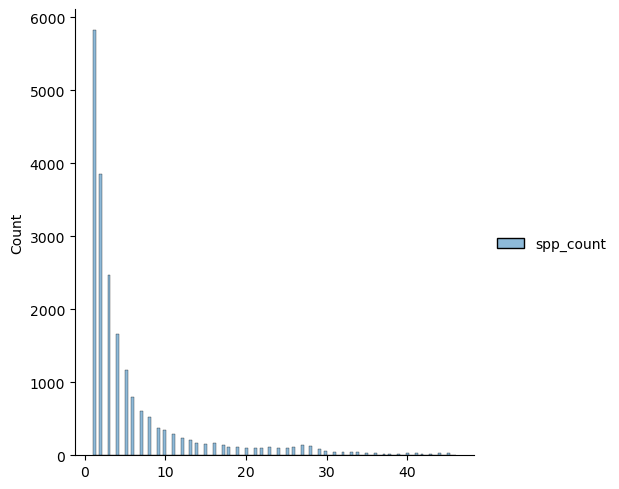

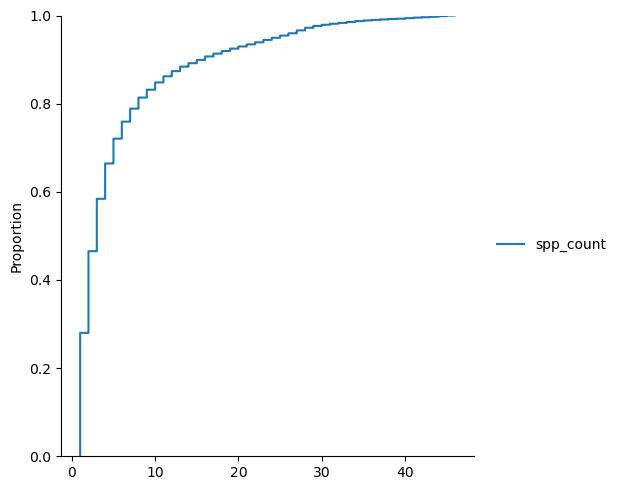

In [12]:

#data = data[data >= 10]
#data = data[data <= 10]

print(len(data.index))

sns.displot(data=data)
sns.displot(data=data,kind='ecdf')

<Axes: xlabel='pLDDT_mean', ylabel='fident'>

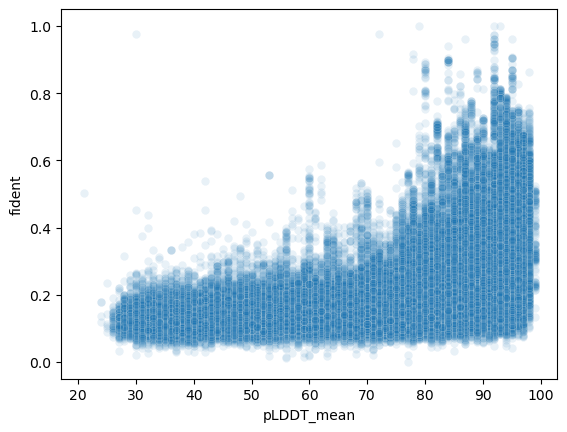

In [13]:
sns.scatterplot(data = df_merged, #.sample(frac=.1), 
                x='pLDDT_mean', 
                y='fident', 
                #marker ='.',
               alpha=0.1)

<Axes: xlabel='pLDDT_mean', ylabel='spp_count'>

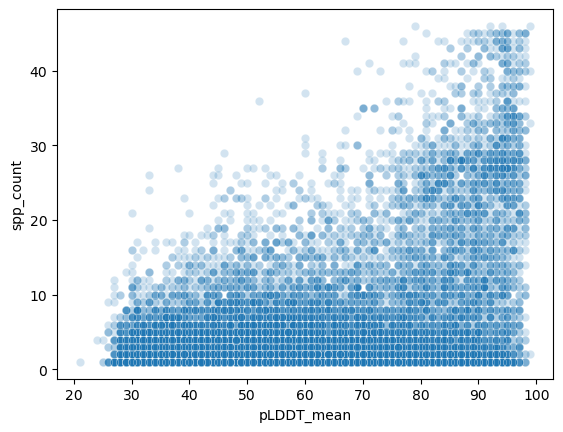

In [14]:
sns.scatterplot(data = df_merged.drop_duplicates(subset=['Ortholog_Group']), #.sample(frac=.1), 
                x='pLDDT_mean', 
                y='spp_count', 
                #marker ='.',
               alpha=0.2)

## Filtrado segun Monzon et al. 2022

<Axes: xlabel='pLDDT_mean', ylabel='spp_count'>

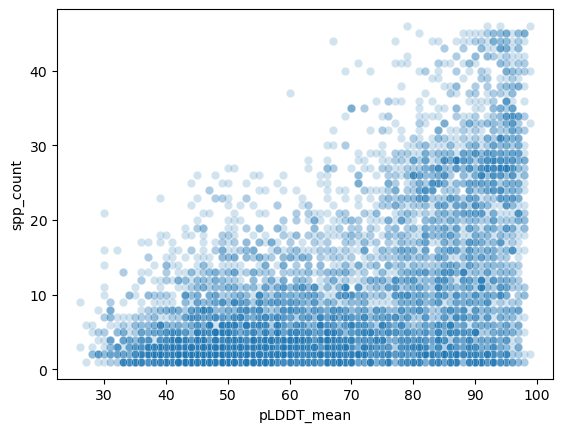

In [15]:
df_merged_filtered = (df_merged[
    (df_merged.evalue.lt(0.0001)) &
    (df_merged['COV_query'] > .75) &
    (df_merged['COV_target'] > .75) 

]
).sort_values('evalue')

sns.scatterplot(data = df_merged_filtered.drop_duplicates(subset=['Ortholog_Group']), #.sample(frac=.1), 
                x='pLDDT_mean', 
                y='spp_count', 
                #marker ='.',
               alpha=0.2)

df_merged_filtered.Ortholog_Group.nunique()

8823

## Lowering filter

In [16]:
df_merged_filtered_lower = df_merged[
    (df_merged['COV_query'] > .5) &
    (df_merged['COV_target'] > .5) &
    (df_merged['evalue'] < 1e-4)]
   # .sort_values('evalue')#.Ortholog_Group.nunique()

<Axes: xlabel='pLDDT_mean', ylabel='spp_count'>

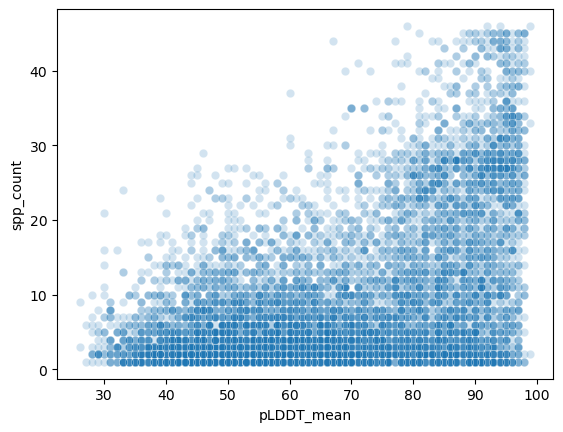

In [17]:
sns.scatterplot(data = df_merged_filtered_lower.drop_duplicates(subset=['Ortholog_Group']), #.sample(frac=.1), 
                x='pLDDT_mean', 
                y='spp_count', 
                #marker ='.',
               alpha=0.2)

<Axes: xlabel='qlen', ylabel='Count'>

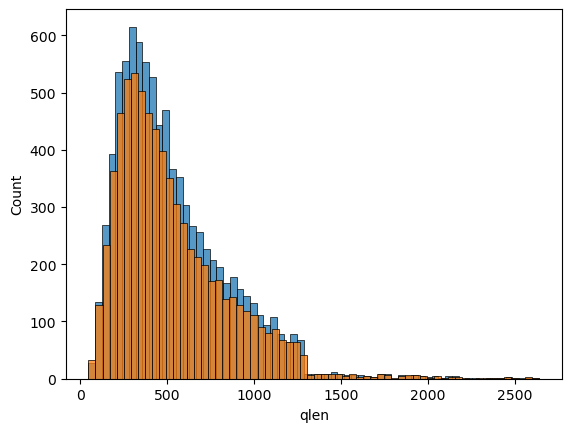

In [30]:
# buscando si hay bias cuando cambio el filtro hacia samll proteins. No parece haber.
fig, ax = plt.subplots()

sns.histplot(df_merged_filtered_lower.drop_duplicates(subset=['Ortholog_Group']).qlen , ax=ax)
sns.histplot(df_merged_filtered.drop_duplicates(subset=['Ortholog_Group']).qlen , ax=ax)

In [18]:
df_merged_filtered_lower.Ortholog_Group.nunique()

8823

In [19]:
df_merged_filtered

,Ortholog_Group,Gene ID,uniprot,pLDDT_mean,query,target,alnlen,fident,evalue,qstart,...,tend,tlen,aligmentinfo,proteome,spp,query_uniprot_accession,target_uniprot_accession,COV_query,COV_target,spp_count
78143,OG6_128065,TcCLB.511745.20,A0A2V2WZH4,82.0,AF-A0A2V2WZH4-F1-model_v4.pdb,AF-P54812-F1-model_v4.pdb.gz,4395,0.705,0.000000,10,...,809,810,84M1I90M1D390M2D128M5D53M7D6M1D16M,UP000001940,CAEEL,A0A2V2WZH4,P54812,0.99,0.97,34
102099,OG6_128065,TcCLB.511745.20,A0A2V2WZH4,82.0,AF-A0A2V2WZH4-F1-model_v4.pdb,AF-A0A0J9XXY9-F1-model_v4.pdb.gz,4391,0.708,0.000000,9,...,811,812,171M1D397M1D2M1D122M4D9M1D46M7D16M2D6M,UP000006672,BRUMA,A0A2V2WZH4,A0A0J9XXY9,0.99,0.97,34
110416,OG6_101162,Tb927.5.2530,Q582B4,77.0,AF-Q582B4-F1-model_v4.pdb,AF-A0A044TDL2-F1-model_v4.pdb.gz,4127,0.399,0.000000,9,...,1049,1051,75M1I21M1I131M6I179M1D35M5D12M1D199M3I11M1D12M...,UP000024404,ONCVO,Q582B4,A0A044TDL2,0.98,1.00,33
38266,OG6_128065,TcCLB.511745.20,A0A2V2WZH4,82.0,AF-A0A2V2WZH4-F1-model_v4.pdb,AF-Q10RP0-F1-model_v4.pdb.gz,5156,0.700,0.000000,0,...,808,809,6M6D571M1D2M1D117M1D58M6D10M4D14M,UP000059680,ORYSJ,A0A2V2WZH4,Q10RP0,1.00,0.98,34
24794,OG6_128065,TcCLB.511745.20,A0A2V2WZH4,82.0,AF-A0A2V2WZH4-F1-model_v4.pdb,AF-Q9P3A7-F1-model_v4.pdb.gz,3730,0.639,0.000000,2,...,814,815,9M12D173M1D393M1D112M2I19M4D58M2D10M,UP000002485,SCHPO,A0A2V2WZH4,Q9P3A7,1.00,0.97,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81765,OG6_196577,BSAL_31655,A0A0S4KNK5,59.0,AF-A0A0S4KNK5-F1-model_v4.pdb,AF-Q9C9P9-F1-model_v4.pdb.gz,116,0.080,0.000099,0,...,244,246,15M2D18M1I29M3I10M10I14M18D11M1D2M2I9M12I12M1D...,UP000006548,ARATH,A0A0S4KNK5,Q9C9P9,1.00,0.98,12
65328,OG6r16_524068,C4B63_301g7,A0A2V2UKD6,45.0,AF-A0A2V2UKD6-F1-model_v4.pdb,AF-C1H137-F1-model_v4.pdb.gz,51,0.130,0.000100,1,...,447,449,60M1D38M1D104M1I46M4I15M1D15M6I19M3I37M2D4M1D1...,UP000002059,PARBA,A0A2V2UKD6,C1H137,1.00,1.00,1
39797,OG6_459508,BSAL_42840,A0A0S4JWA6,51.0,AF-A0A0S4JWA6-F1-model_v4.pdb,AF-A0A5K4F3D1-F1-model_v4.cif.gz,51,0.103,0.000100,1,...,343,344,70M3I58M4I21M1I6M3I5M2I6M5D8M3D8M46D5M6D26M27D44M,UP000008854,SCHMA,A0A0S4JWA6,A0A5K4F3D1,0.98,1.00,8
48414,OG6_172105,BSAL_07465,A0A0S4KHF5,58.0,AF-A0A0S4KHF5-F1-model_v4.pdb,AF-A0A175WDH8-F1-model_v4.cif.gz,103,0.114,0.000100,10,...,413,415,13M2I46M9I32M5D6M6D4M3D22M5D37M15D6M9D11M1I15M...,UP000078237,9PEZI1,A0A0S4KHF5,A0A175WDH8,0.84,1.00,16
